In [0]:
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np
import requests

from torchvision import models, transforms
import torch.optim as optim
import torch

%matplotlib inline

In [10]:
# Get the "features" portion of VGG19
vgg_features = models.vgg19(pretrained=True).features

for params in vgg_features.parameters():
  params.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: ", device)
vgg_features.to(device)

Running on device:  cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' 
       Load and transform an image. Image is <= 400 pixels
       in the x-y dimension.
    '''
    
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard the alpha channel and add the Batch Size dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# Function for un-normalizing an image and converting from a Tensor image 
# to a NumPy image

def im_convert(tensor):
    """ 
      Display a tensor as an image. 
    """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

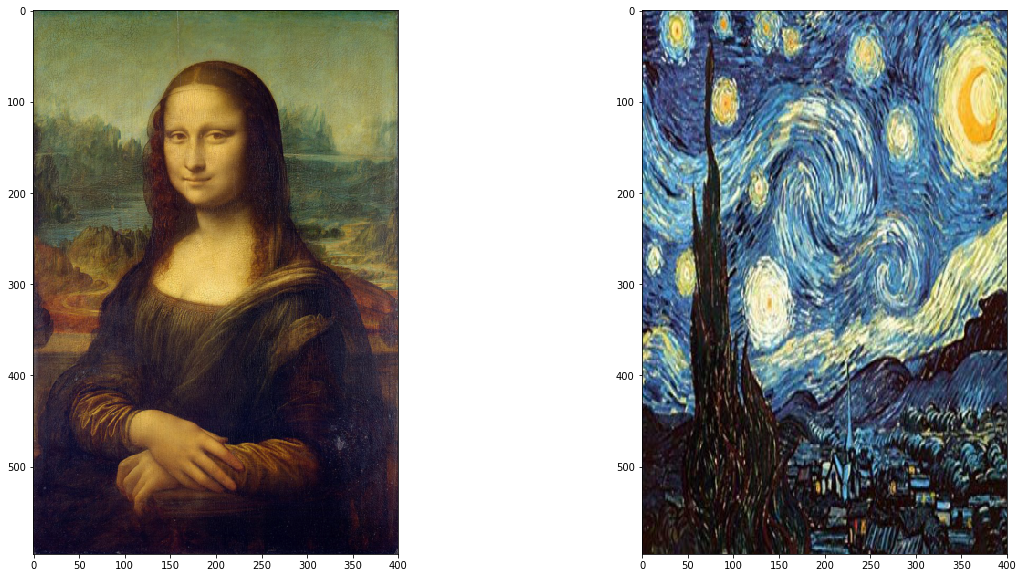

In [36]:
# Load content and style image
content = load_image("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg").to(device)
style = load_image("https://images-na.ssl-images-amazon.com/images/I/61ySbUOxYRL._SX425_.jpg", shape=content.shape[-2:]).to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):
  
  """
      Run an image through the VGG-16 Model and get the features for a set of
      layers. Defaults to layers given in Gatys et al paper - 2016
  """
  
  if layers is None:
    layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content representation
                  '28': 'conv5_1'}
  
  features = {}
  x = image
  
  for name, layer in model._modules.items():
    x = layer(x)
    
    if name in layers:
      features[layers[name]] = x
  
  return features

In [0]:
def gram_matrix(tensor):
  
  """
    Calculate Gram matrix of a given tensor
  """
  
  _, d, h, w = tensor.size()
  
  tensor = tensor.view(d, h * w)
  
  gram = torch.mm(tensor, tensor.t())
  
  return gram

## Gram matrix for a tensor is calculated as follows:
1. Flatten the tensor to dimensions `depth * (height * width)`. Results is a 2D matrix of `height = depth of tensor`, `width = height * width of tensor`
2. Matrix multiply the resultant matrix with its transpose: `Gram * Gram'`
3. Resultant matrix is the gram matrix of the tensor

In [0]:
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

# Extract gram matrix for style representation
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

# Weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.4,
                 'conv4_1': 0.6,
                 'conv5_1': 0.8}

content_weight = 1  # alpha
style_weight = 1e7  # beta

* By weighting earlier layers (conv1_1 and conv2_1) more, we get larger style artifacts in the resulting target image. 
* Weighting later layers, there will be more emphasis on smaller features. 
* `conv4_2`  is excluded since its used for content representation

Total loss:  311723360.0


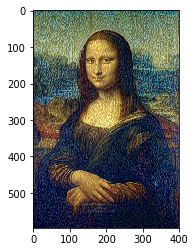

Total loss:  107975968.0


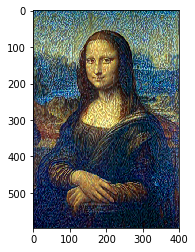

Total loss:  49795976.0


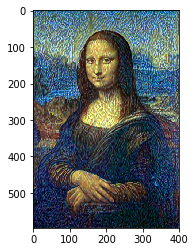

Total loss:  24164620.0


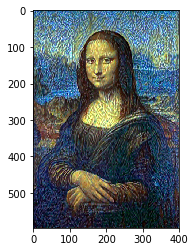

Total loss:  13179477.0


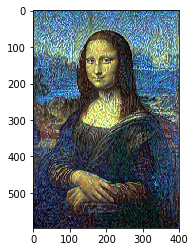

Total loss:  8194023.5


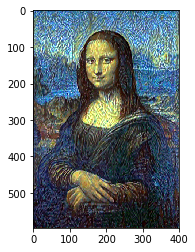

Total loss:  5607990.5


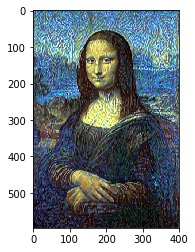

Total loss:  4085704.0


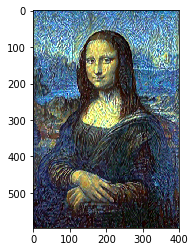

Total loss:  3111344.0


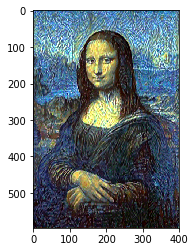

Total loss:  2447833.0


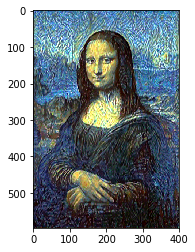

Total loss:  1978511.75


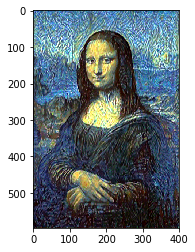

Total loss:  1635392.875


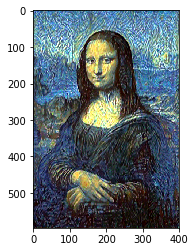

Total loss:  1374895.75


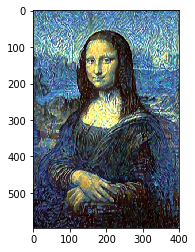

Total loss:  1175515.625


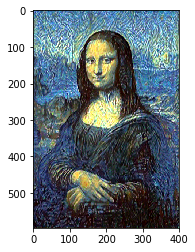

Total loss:  1019520.9375


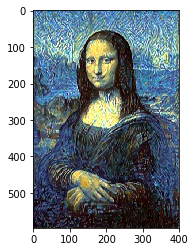

In [40]:
display_gap = 500

# Hyperparameters
iters = 7500
lr = 3e-3
optimizer = optim.Adam([target], lr=lr)

for ii in range(1, iters+1):
  
  # Extract Target features
  target_features = get_features(target, vgg_features)
  
  # Calculate Content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
  
  # Calculate Style loss
  style_loss = 0
  
  for layer in style_weights:
    
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    
    style_gram = style_grams[layer]
    
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)
  
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % display_gap == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

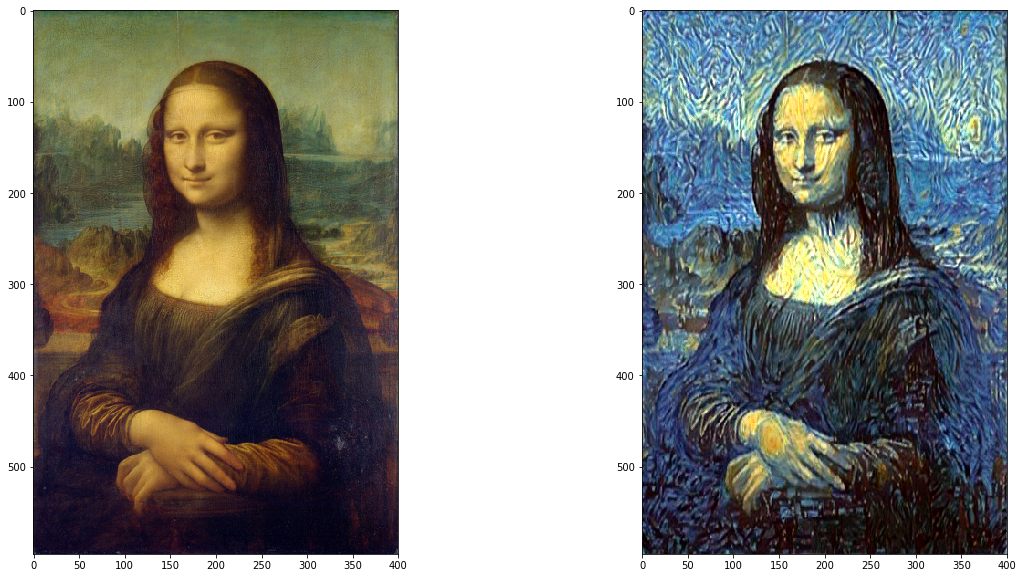

In [41]:
# display content and final stylized target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))